In [303]:
!pip3 install pillow
!pip3 install numba

    100% |████████████████████████████████| 1.9MB 4.1MB/s ta 0:00:011   51% |████████████████▋               | 993kB 7.9MB/s eta 0:00:01
    100% |████████████████████████████████| 15.9MB 432kB/s eta 0:00:01   34% |███████████▏                    | 5.5MB 13.2MB/s eta 0:00:01    66% |█████████████████████▏          | 10.5MB 8.9MB/s eta 0:00:01    69% |██████████████████████▎         | 11.0MB 10.2MB/s eta 0:00:01    95% |██████████████████████████████▋ | 15.2MB 6.6MB/s eta 0:00:01


In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from numba import jit, autojit
from PIL import Image, ImageOps
import time

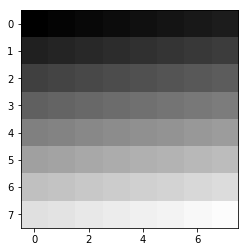

In [58]:
def show_vector(v, width=8, vmax=255):
    plt.imshow(np.split(np.array(v, dtype=np.float32), width), vmin=0, vmax=255, cmap='gray')    
    
img1 = [x for x in range(0,256,4)]
show_vector(img1)

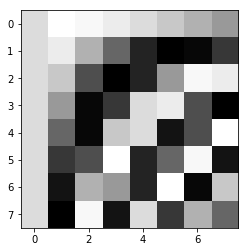

In [234]:
N = 8
PI = math.pi

def phi(k, i):
    if k == 0:
        return 1 / math.sqrt(N)
    else:
        return math.sqrt(2/N) * math.cos(((2*i+1)*k*PI) / (2*N))

p = [phi(k,i) for i in range(N) for k in range(N)]

plt.imshow(np.split(np.array(p, dtype=np.float32),8), cmap='gray')

In [235]:
@autojit
def dct(f):
    F = [0] * N * N
    for m in range(N):
        for n in range(N):
            vv = 0.0
            for yy in range(0, N*8, 8):
#                for x in range(N):
#                    v += f[x+y*8] * p[x*8+m] * p[y*8+n]
                v  = f[  yy] * p[   m]
                v += f[1+yy] * p[ 8+m]
                v += f[2+yy] * p[16+m]
                v += f[3+yy] * p[24+m]
                v += f[4+yy] * p[32+m]
                v += f[5+yy] * p[40+m]
                v += f[6+yy] * p[48+m]
                v += f[7+yy] * p[56+m]
                vv += v * p[yy+n]
            F[m*8+n] = int(vv)
    return F

@autojit
def idct(F):
    f = [0] * N * N
    for x in range(N):
        xx = x * 8
        for y in range(N):
#            for m in range(N):
#                for n in range(N):
#                    v += F[m*8+n] * p[x*8+m] * p[y*8+n]
            vv = 0.0
            for n in range(N):
                v  = F[   n] * p[xx  ]
                v += F[ 8+n] * p[xx+1]
                v += F[16+n] * p[xx+2]
                v += F[24+n] * p[xx+3]
                v += F[32+n] * p[xx+4]
                v += F[40+n] * p[xx+5]
                v += F[48+n] * p[xx+6]
                v += F[56+n] * p[xx+7]
                vv += v * p[y*8+n]
            f[x+y*8] += int(vv)
    return f

<module 'matplotlib.pyplot' from '/home/reki/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/pyplot.py'>

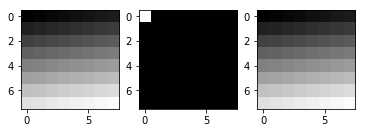

In [236]:
F = dct(img1)
#F[np.absolute(F) < 1] = 0
f = idct(F)
plt.subplot(131)
show_vector(img1)
plt.subplot(132)
show_vector(F)
plt.subplot(133)
show_vector(f)
plt

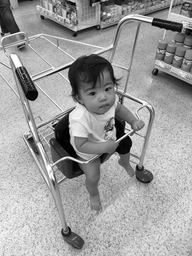

(192, 256)

In [237]:
img = ImageOps.grayscale(Image.open('/home/reki/git/mahiro-cart.jpg'))
size=256
img.thumbnail((size,size), Image.ANTIALIAS)
display(img)
w,h = img.width, img.height
w,h

In [239]:
_out = [0]*w*h
_in = list(img.getdata())

@autojit
def replace(x,y,img):
    for i in range(N):
        for j in range(N):
            _out[(y+i)*w+(x+j)] = img[i*8+j]

def measure():
    y = 0
    start = time.time()
    for x in range(0, w, 8):
        crop = [_in[dy+dx] for dy in range(y*w,(N+y)*w,w) for dx in range(x,N+x)]
        out = idct(dct(crop))
        replace(x,y,crop)
    print((time.time() - start)/24)

for i in range(10):
    measure()

def roundtrip():
    for y in range(0, h, 8):
        #display(y)
        for x in range(0, w, 8):
            crop = [_in[dy+dx] for dy in range(y*w,(N+y)*w,w) for dx in range(x,N+x)]
            out = idct(dct(crop))
            replace(x,y,crop)

0.03819830218950907
0.012051641941070557
0.010500341653823853
0.0067305465539296465
0.007504572470982869
0.006379127502441406
0.007030099630355835
0.006248017152150472
0.008757720390955607
0.006284038225809733


<module 'matplotlib.pyplot' from '/home/reki/.pyenv/versions/3.6.5/lib/python3.6/site-packages/matplotlib/pyplot.py'>

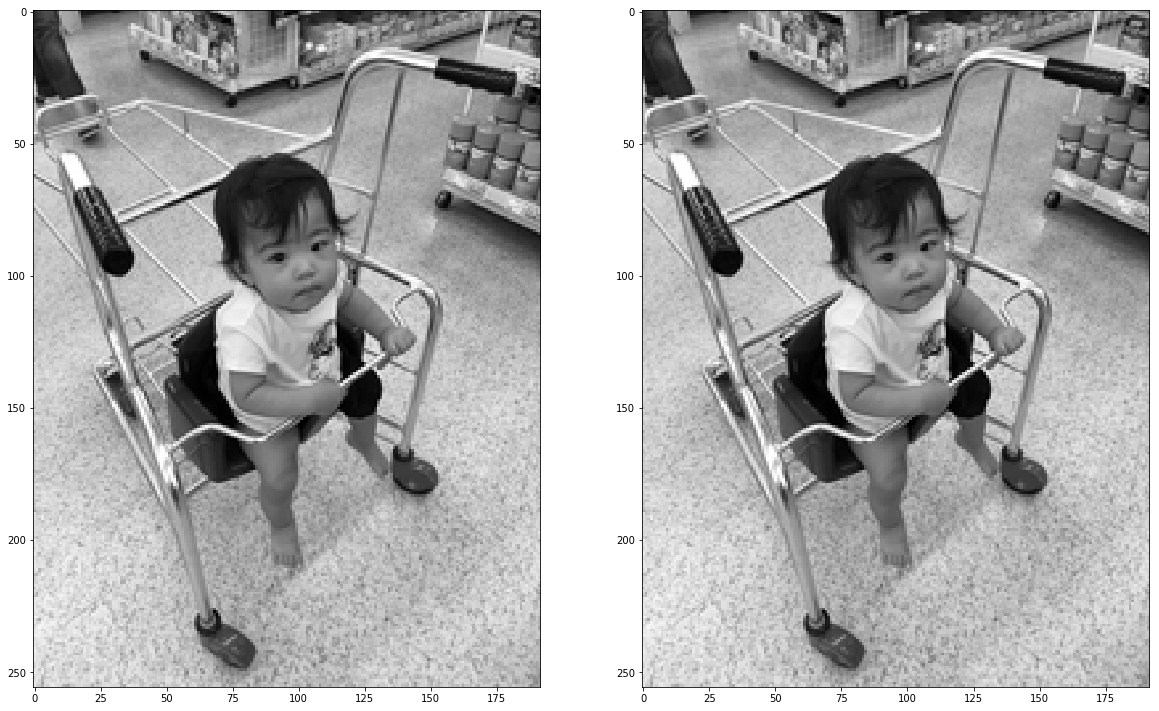

In [228]:
roundtrip()
fig = plt.figure(figsize=(20,20))
fig.add_subplot(121)
plt.imshow(np.split(np.array(_in, dtype=np.float32), h), cmap='gray')
fig.add_subplot(122)
plt.imshow(np.split(np.array(_out, dtype=np.float32), h), vmin=0, vmax=255, cmap='gray')    
plt